### Project locations of animal tracks from video space to landscape space

In [1]:
import copy
import glob
import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import pandas as pd
import utm

# local .json file with local path info
ungulates_root = os.path.dirname(os.getcwd())
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])


import koger_general_functions as kgf
import mapping_functions as kmap
from drone_movement import create_gt_segment_dicts

plt.style.use('dark_background')

In [5]:
# Distance away from ground for location to be considered correct when
# projecting locations onto map (meters)
correct_threshold = 0.1
# Max guesses to find location along ray that within correct_threshold of ground
max_guesses = 50
# Expected height above ground in meteres (doesn't need to be accurate)
initial_mu = 80
# Expected height above ground of animals
object_height = 1

verbose = True
save = True
# new_style should be True is using file format used througout worked examples
new_style = True

observation_name = "observation088"
# Name of the track file that should be projected into landscape
tracks_name = "tracks-complete.npy"
# Name of folder where data extracted in "extract_drone_movement.ipynb" was saved
drone_movement_folder_name = "worked_examples_drone_movement"
# Project name assosiated with the saved pix4d files
pix4d_project_name = "observation088"

In [6]:
# Load files based on above names. Shouldn't need to be changed if previous
# notebooks were used
root_folder = os.path.join(local_paths["processed_folder"], observation_name)

if new_style:
    tracks_file = os.path.join(root_folder, tracks_name)
else:   
    tracks_file = os.path.join(root_folder, "localizations", tracks_name)
tracks = np.load(tracks_file, allow_pickle=True)

frame_folders_root = os.path.join(local_paths["base_frames_folder"], observation_name) 
frame_files = kgf.get_observation_frame_files(frame_folders_root)

pix4d_folder = os.path.join(local_paths["pix4d_folder"], observation_name)
pix4d_info = kmap.get_pix4d_info(pix4d_folder, pix4d_project_name)

anchor_obs_inds = kmap.get_anchor_obs_indexes(pix4d_info['pmatrices'], 
                                              frame_files=frame_files)

drone_movement_folder = os.path.join(frame_folders_root, drone_movement_folder_name)
# List of affine movement matricies for each frame in each segment
segment_movement_files = glob.glob(
    os.path.join(drone_movement_folder,"drone_movement_segment_*.npy"))
segment_movements_list = [np.load(file) for file in sorted(segment_movement_files)]

0 frames processed
10000 frames processed
20000 frames processed
30000 frames processed
40000 frames processed
50000 frames processed
60000 frames processed
70000 frames processed
80000 frames processed
90000 frames processed


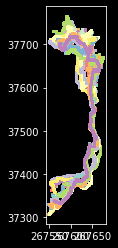

In [7]:
utm_tracks = kmap.video_tracks_to_utm(tracks, pix4d_info, anchor_obs_inds, 
                                 segment_movements_list, frame_files, 
                                 mu_est=initial_mu, max_guesses=max_guesses, 
                                 correct_threshold=correct_threshold, 
                                 object_height=object_height, verbose=verbose,
                                     correct_anchor_error=True)

for t in utm_tracks:
    plt.scatter(t[:,0], t[:,1], s=3)
plt.gca().set_aspect('equal')

if save:
    utm_tracks_file = os.path.join(pix4d_folder, 'utm_tracks.npy')
    np.save(utm_tracks_file, utm_tracks)

### We can visualize these tracks on the landscape maps

In [9]:
# Load the rgb orthomosaic
geotif_image_file = os.path.join(pix4d_folder, "3_dsm_ortho", "2_mosaic",
                                 f"{observation_name}_transparent_mosaic_group1.tif") 
image_gtif = gdal.Open(geotif_image_file)

gtif_transform = image_gtif.GetGeoTransform()
x_origin = gtif_transform[0]
y_origin = gtif_transform[3]
pixel_width = gtif_transform[1]
pixel_height = gtif_transform[5]

pix4d_info = {'x_origin': x_origin,
              'y_origin': y_origin,
              'pixel_width': pixel_width,
              'pixel_height': pixel_height}

bands = []
for band_num in range(1, 4):
    srcband = image_gtif.GetRasterBand(band_num)
    a = srcband.ReadAsArray()
    bands.append(a)
orthomap = np.stack(bands, 2)

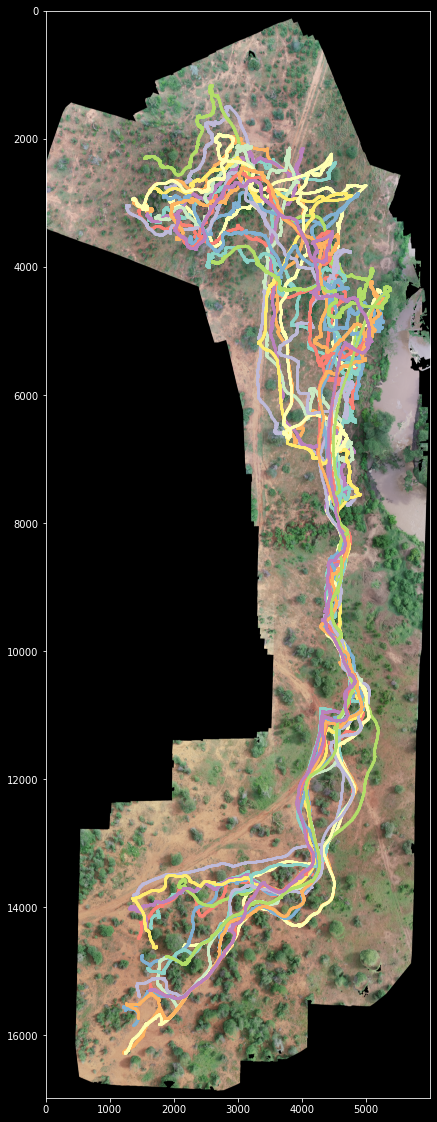

In [10]:
plt.figure(figsize=(20, 20))
plt.imshow(orthomap)

for utm_track in utm_tracks:
    raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info, image_scale=1)
    
    plt.scatter(raster_track[:, 0], raster_track[:, 1], s=1)